<a href="https://colab.research.google.com/github/MatteoRigoni/MachineLearningPlayground/blob/master/NLP_Progetto_MatteoRigoni_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Definizione del progetto

L'azienda ProfessionAI vuole realizzare una libreria capace di fare analisi delle email ricevute.

Nello specifico, il CEO ha richiesto di identificare le email di tipo SPAM sulle quali fare analisi contenutistiche.

Il CTO nello specifico ti fornisce un dataset e ti chiede di:
- Addestrare un classificatore per identificare SPAM
- Individuare i Topic principali tra le email SPAM presenti nel dataset
- Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.
- Estrarre dalle mail NON SPAM le Organizzazioni presenti.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

RANDOM_SEED = 10

#Analisi del dataset

Si carica il dataset composto da 5171 esempi di mail e si fa una prima analisi sui dati.

Per ogni record si ha un ID univoco, di cui non ci importa nell'addestramento del modello, inoltre label e label_num indicano la stessa cosa semplicemente in forma diversa (testuale e codificata), per cui teniamo solo la seconda colonna, dove 1=SPAM, 0=NON SPAM)

La verifica sui campi non valorizzati dà esito positivo, quindi non servono operazioni per compensare.

Si verifica la suddivisione delle due label (spam oppure non spam), c'è un rapporto di circa 2:1, nel caso non si raggiunga un risultato soddisfacente si proverà a bilanciare il dataset.

Si ricavano inoltre delle statistiche sulle lunghezze dei corpi delle mail, che saranno poi utili nella fase di preprazione dei dati.

In [3]:
DATASET_URL = 'https://raw.githubusercontent.com/ProfAI/natural-language-processing/3f46b2e893c98c45b67d4f4d422aefbb19738286/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv'
df = pd.read_csv(DATASET_URL, encoding='ISO-8859-1', sep=',')
display(HTML("<h3><b>Sample rows from dataset:</b></h3>"))
print(df.head().to_string(max_colwidth=80))

display(HTML("<h3><b>N/A values for each column:</b></h3>"))
print(df.isnull().sum())

display(HTML("<h3><b>Labels distribution:</b></h3>"))
print(df['label'].value_counts())

display(HTML("<h3><b>Stats about length of texts:</b></h3>"))
print(df['text'].apply(len).describe())

df_optimized = df.drop(columns=['Unnamed: 0', 'label'])

display(HTML("<h3><b>Sample rows from optimized dataset:</b></h3>"))
print(df_optimized.head().to_string(max_colwidth=80))

   Unnamed: 0 label                                                                             text  label_num
0         605   ham  Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note ...          0
1        2349   ham  Subject: hpl nom for january 9 , 2001\n( see attached file : hplnol 09 . xls...          0
2        3624   ham  Subject: neon retreat\nho ho ho , we ' re around to that most wonderful time...          0
3        4685  spam  Subject: photoshop , windows , office . cheap . main trending\nabasements da...          1
4        2030   ham  Subject: re : indian springs\nthis deal is to book the teco pvr revenue . it...          0


Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


label
ham     3672
spam    1499
Name: count, dtype: int64


count     5171.00000
mean      1029.74531
std       1505.10317
min         10.00000
25%        238.00000
50%        529.00000
75%       1214.00000
max      31860.00000
Name: text, dtype: float64


                                                                              text  label_num
0  Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note ...          0
1  Subject: hpl nom for january 9 , 2001\n( see attached file : hplnol 09 . xls...          0
2  Subject: neon retreat\nho ho ho , we ' re around to that most wonderful time...          0
3  Subject: photoshop , windows , office . cheap . main trending\nabasements da...          1
4  Subject: re : indian springs\nthis deal is to book the teco pvr revenue . it...          0


#Preprocessing del dataset

In questo step si va a ripulire il campo relativo alla mail da caratteri e sequenze di stringhe non utili per capire se o meno spam, in modo da alleggerirlo, con benefici nella fase di training.

Si fa la tokenizzazione, per suddividere le frasi in singole parole da dare in pasto alla fase di training. Su queste si effettua anche la lemmetizzazione, in modo tale da ricondurre le forme contratte o estese alla loro parola base.

Si usa la metodologia TF-IDF per trasformare i tokeni in valore numerico.
Questa tecnica tiene conto della frequenza della parola nei documenti per attribuirgli una determinata importanza.

Infine si suddivide il dataset in train e test, usando lo stratify visto che il dataset è leggermente sbilanciato.

Per la parte di pulizia del testo e tokenizzazione si usano le seguenti libereie:
- [NLTK](https://www.nltk.org/#)
- [SPACY](https://spacy.io/usage)
- [RE](https://docs.python.org/3/library/re.html) per le espressioni REGEX

Di seguito si scaricano alcuni pacchetti specifichi per la lingua del dataset (inglese)

In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import spacy
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
def clean_text(text):
    text = text.replace('Subject: ', '')  #rimozione parti fisse ripetute in ogni riga

    text = re.sub(r'\W', ' ', text) #punteggiatura, non importante al fine del processo di dected dello spam
    text = re.sub(r'\d+', '', text)  #numeri, non importanti al fine del processo di dected dello spam
    text = text.lower()  #conversione del testo in minuscolo, al fine di semplificare il dato
    text = re.sub(r'\s+', ' ', text)  #rimozione spazi extra e 'a capo'
    text = text.strip()  #trim del testo

    return text

In [6]:
def pre_process_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [7]:
df_optimized['cleaned_text'] = df_optimized['text'].apply(clean_text)

display(HTML("<h3><b>Sample rows from optimized and cleaned dataset:</b></h3>"))
print(df_optimized.head().to_string(max_colwidth=80))

                                                                              text  label_num                                                                     cleaned_text
0  Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note ...          0  enron methanol meter this is a follow up to the note i gave you on monday pr...
1  Subject: hpl nom for january 9 , 2001\n( see attached file : hplnol 09 . xls...          0                      hpl nom for january see attached file hplnol xls hplnol xls
2  Subject: neon retreat\nho ho ho , we ' re around to that most wonderful time...          0  neon retreat ho ho ho we re around to that most wonderful time of the year n...
3  Subject: photoshop , windows , office . cheap . main trending\nabasements da...          1  photoshop windows office cheap main trending abasements darer prudently fort...
4  Subject: re : indian springs\nthis deal is to book the teco pvr revenue . it...          0  re indian springs this deal is

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_optimized['cleaned_text'] = df_optimized['cleaned_text'].apply(pre_process_text)

display(HTML("<h3><b>Sample rows from optimized, cleaned and pre-processed dataset:</b></h3>"))
print(df_optimized.head().to_string(max_colwidth=80))

                                                                              text  label_num                                                                     cleaned_text
0  Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note ...          0  enron methanol meter follow note gave monday preliminary flow data provided ...
1  Subject: hpl nom for january 9 , 2001\n( see attached file : hplnol 09 . xls...          0                            hpl nom january see attached file hplnol xl hplnol xl
2  Subject: neon retreat\nho ho ho , we ' re around to that most wonderful time...          0  neon retreat ho ho ho around wonderful time year neon leader retreat time kn...
3  Subject: photoshop , windows , office . cheap . main trending\nabasements da...          1  photoshop window office cheap main trending abasement darer prudently fortui...
4  Subject: re : indian springs\nthis deal is to book the teco pvr revenue . it...          0  indian spring deal book teco p

In [9]:
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df_optimized['cleaned_text'])
unique_words = len(vectorizer.get_feature_names_out())

print("\nNumber of unique words in documents:", unique_words)


Number of unique words in documents: 43159


In [10]:
tfidf = TfidfVectorizer(max_features=int(unique_words/5)) #si prova con questo valore iniziale, se il modello non si comporta bene, si prova a aumentarlo
x = tfidf.fit_transform(df_optimized['cleaned_text']).toarray()
y = df_optimized['label_num']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

print("Training dataset's shape:", x_train.shape)
print("Test dataset's shape:", x_test.shape)

Training dataset's shape: (4136, 8631)
Test dataset's shape: (1035, 8631)


#Classificazione

Si addestra ora un modello per identificare se il testo appartiene alla categoria SPAM oppure no.

Si inizia da un semplice "LogisticRegression", che ottiene già ottimi risultati, con un accuracy del 99% e pochi falsi positivi/negativi.

Tuttavia, visto che il dataset è piccolo e quindi la fase di training non è molto esosa, si prova anche con un modello "SVM" che ottiene degli score appena migliori, per cui si decide di tenere per buono questo modello.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

In [13]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_pred_log_reg = log_reg.predict(x_test)

display(HTML("<h3><b>Logistic Regression</b></h3>"))
print('\nAccuracy:', accuracy_score(y_test, y_pred_log_reg))
print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred_log_reg))
print('\nClassification report:\n', classification_report(y_test, y_pred_log_reg))
print('-------------------------------------------------------------------------------\n')


Accuracy: 0.9903381642512077

Confusion matrix:
 [[726   9]
 [  1 299]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       735
           1       0.97      1.00      0.98       300

    accuracy                           0.99      1035
   macro avg       0.98      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035

-------------------------------------------------------------------------------



In [14]:
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

display(HTML("<h3><b>SVM with linear kernel</b></h3>"))
print('\nAccuracy:', accuracy_score(y_test, y_pred_svm))
print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred_svm))
print('\nClassification report:\n', classification_report(y_test, y_pred_svm))
print('-------------------------------------------------------------------------------\n')


Accuracy: 0.991304347826087

Confusion matrix:
 [[728   7]
 [  2 298]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       735
           1       0.98      0.99      0.99       300

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035

-------------------------------------------------------------------------------



#Topic Modelling dello SPAM

Per l'identificazione dei principali argomenti nelle mail di spam si una l'agoritmo [LDA](https://techblog.smc.it/it/2021-10-22/topic-modelling)

Si aggiunge un ulteriore colonna 'cleaned_text_topic' dove si rimuovono anche alcuni termini legati al markup HTML emersi durante l'analisi dei topic.
Non si è trovato un modo empirico per farlo, per cui si è andati in maniera progressiva a scremare le parole non significative che emergevano dai topic, oltre a escludere l'analisi su parole con meno di 3 caratteri, che hanno poca valenza semantica. Questo non si fa sul dataset originale, in quanto potrebbero essere invece utili nel distinguere 'SPAM' da 'NON SPAM'

Una volta pulito il dataset, si procede alla tokenizzazione e creazione di un dizionario per associare ogni termine a un id univoco.

Al termine del processing col modello LDA, si stampano i topic, per ognuno sono mostrate le parole chiave associate al relativo peso.

In [15]:
from nltk.tokenize import word_tokenize
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from bs4 import BeautifulSoup

In [16]:
extra_stopwords = ['size', 'width', 'face', 'darial', 'fontfont', 'bgcolor', 'color', 'index', 'image', 'border', 'family' 'color', 'http', 'font', 'height', 'nbsp', 'html', 'body', 'href', 'style', 'click', 'table', 'align', 'valign', 'center','strong', 'span']

In [17]:
spam_texts = df_optimized[df_optimized['label_num'] == 1]['cleaned_text']
display(HTML("<h3><b>Sample rows of SPAM records:</b></h3>"))
print(spam_texts.head())

3     photoshop window office cheap main trending ab...
7     looking medication best source difficult make ...
10    vocable rnd word asceticism vcsc brand new sto...
11    report wffur attion brom est inst siupied pgst...
13    vic odin n ow berne hotbox carnal bride cutwor...
Name: cleaned_text, dtype: object


In [18]:
spam_tokens = [[word for word in word_tokenize(text) if word.strip().lower() not in extra_stopwords and len(word) > 3]   for text in spam_texts]
dictionary = Dictionary(spam_tokens)
corpus = [dictionary.doc2bow(text) for text in spam_tokens]

print("Dictionary:", dictionary)
print("Sample corpus (list of word_id + word_frequency inside document):", corpus[:1])

Dictionary: Dictionary<32645 unique tokens: ['abasement', 'academy', 'affluent', 'badness', 'bayda']...>
Sample corpus (list of word_id + word_frequency inside document): [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)]]


In [19]:
NUM_TOPICS = 5 #numero dei principali topic che ci interessa analizzare
NUM_WORDS_FOR_EACH_TOPIC = 5 #numero parole chiave che contribuiscono al topic

lda_model = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, passes=15, id2word=dictionary, random_state=RANDOM_SEED)
topics = lda_model.print_topics(num_words=NUM_WORDS_FOR_EACH_TOPIC)

for idx, topic in topics:
    print(f'{idx+1}° topic : {topic}')

1° topic : 0.003*"moopid" + 0.003*"hotlist" + 0.003*"money" + 0.002*"fund" + 0.002*"want"
2° topic : 0.014*"company" + 0.008*"statement" + 0.007*"stock" + 0.007*"information" + 0.006*"security"
3° topic : 0.011*"pill" + 0.005*"viagra" + 0.004*"cialis" + 0.004*"time" + 0.004*"prescription"
4° topic : 0.003*"number" + 0.003*"claim" + 0.002*"prize" + 0.002*"program" + 0.002*"international"
5° topic : 0.009*"price" + 0.007*"computron" + 0.006*"window" + 0.005*"microsoft" + 0.005*"message"


I topic di spam ottenuti sono sensati:
- il 1° sembra legato a questo sito di spam "www.moopid.com", ricorrente nel dataset nella categoria SPAM
- il 2° pare legato a tematiche aziendali e finanziarie
- il 3° sembra legato a tematiche di farmaci specici per uomini
- il 4°, vedendo degli esempi nel dataset, sembra correlato a offerte di prodotti, anche se è piuttosto generico come parole chiave
- il 5° pare legato a offerte di vendita PC, inerenti un'ipotetica azienda 'Computron' (www . computron - me . com), dove 'window' è la versione contratta di 'Windows'. Il termine 'Computron' è molto ricorrente nel dataset, con 242 occorrenze.

#Distanza semantica tra i topic di SPAM

Lo scopo è capire quanto sono assimilabili i topic di SPAM identificativi. La tecnica utilizzata è basata sulla distanza del coseno, che misura l'angolo tra due vettori, quindi più l'angolo è vicino allo zero, maggiore sarà la similarità degli argomenti.

Si disegna poi una matrice per vedere meglio la relazione tra i topic.

Si evince che tutti i topic hanno tra loro una distanza compresa tra 0.58 e 0.78, quindi possono essere considerati piuttosto slegati tra loro. Se ci fossero stati valori prossimi allo zero, si sarebbe potuto valutare di aggregarli in quanto molto simili.

In [20]:
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
topic_vectors = lda_model.get_topics()
cosine_dist_matrix = cosine_distances(topic_vectors)

display(HTML("<h3><b>Distance matrix:</b></h3>"))
print(cosine_dist_matrix)

[[0.         0.7489922  0.7146584  0.7060684  0.7763693 ]
 [0.7489922  0.         0.69362754 0.5821574  0.69738454]
 [0.7146584  0.69362754 0.         0.69584024 0.6191783 ]
 [0.7060684  0.5821574  0.69584024 0.         0.70292556]
 [0.7763693  0.69738454 0.6191783  0.70292556 0.        ]]


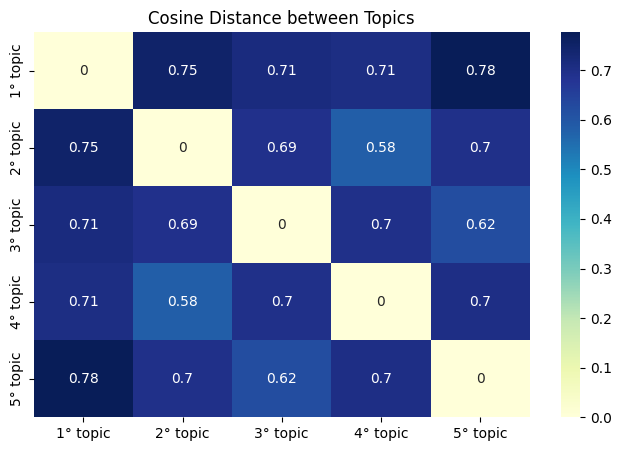

In [22]:
plt.figure(figsize=(8, 5))
sns.heatmap(cosine_dist_matrix, annot=True, cmap="YlGnBu", xticklabels=[f"{i+1}° topic" for i in range(NUM_TOPICS)], yticklabels=[f"{i+1}° topic" for i in range(NUM_TOPICS)])
plt.title("Cosine Distance between Topics")
plt.show()

#Riconoscimento delle Organizzazioni nelle mail ufficiali

In questa fase si sfrutta sempre la libreria SPACY per effettuare il NER, ovvero il processo di estrazioni di nomi di 'entità'.

> Fonte: [SpaCy NER](https://spacy.io/universe/project/video-spacys-ner-model-alt)

Dopo l'estrazione si accorpano tutti i valori e si stampano alcuni valori per capire la qualità dell'analisi.

Il risultato non è ottimale e sembra riportare tanti falsi positivi, si è provato usando anche un model più esteso come "en_core_web_lg" senza ottenere però miglioramenti significativi.

In [23]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [24]:
def extract_organizations(text):
    doc = nlp(text)
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return organizations

In [25]:
not_spam_emails = df_optimized[df_optimized['label_num'] == 0]['cleaned_text']
df_optimized['orgs'] = not_spam_emails.apply(extract_organizations)
display(HTML("<h3><b>Sample organizations with 'en_core_web_sm':</b></h3>"))
print(df_optimized[['text', 'orgs']].head())

                                                text                    orgs
0  Subject: enron methanol ; meter # : 988291\nth...  [enron methanol meter]
1  Subject: hpl nom for january 9 , 2001\n( see a...                      []
2  Subject: neon retreat\nho ho ho , we ' re arou...          [shop antique]
3  Subject: photoshop , windows , office . cheap ...                     NaN
4  Subject: re : indian springs\nthis deal is to ...                      []


In [26]:
unique_organizations = set()

for orgs in df_optimized['orgs'].dropna():
    unique_organizations.update(orgs)

display(HTML("<h3><b>Unique sample organizations fetched:</b></h3>"))
for org in list(unique_organizations)[:20]:
  print(org)

ami chokshi corp enron dscottl
texas eastern
enron capital trade resource corp evelyn
michelle leblanc corp tax ling li
exxon vance deal created
jeff johnson corp enron enron
mgi
enron corp
detroit phc
rank communication getting imput
el paso merchant energy pgev
eb common data corp environment
school university texas
slum house
needville
tri union development corp jan
petroleum apache corp barrett resource crosstex
morgan point
enron medical network
subject fw energy service
